In [1]:
import pandas as pd
import numpy as np
import plotnine
from plotnine import ggplot, geom_bar, geom_point, aes, stat_smooth, facet_wrap
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('../Data/conversion_project.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
df = df.astype({'converted':object,'new_user':object})

In [5]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Explortary data analysis

In [6]:
df = df.astype({'converted':int})
country_df = df[['country','converted']].groupby(by = 'country').mean()
country_df.rename(columns = {'converted':'conversion_rate'},inplace = True)

In [7]:
country_df

,conversion_rate
country,
China,0.001332
Germany,0.062500
UK,0.052632
US,0.037801


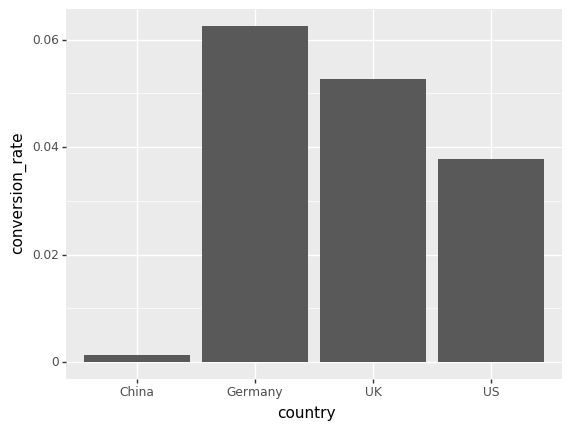

<ggplot: (8790568634985)>

In [8]:
country_df.reset_index(inplace = True)
ggplot(country_df,aes(x = 'country',y = 'conversion_rate'))+geom_bar(stat = "identity")

It seems like users from China have a much lower conversion rate. 

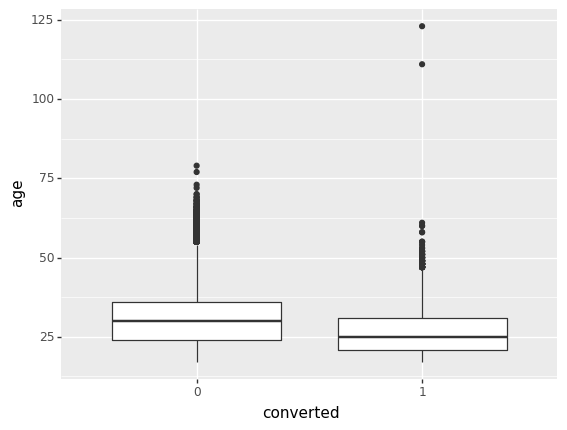

<ggplot: (8790568641489)>

In [9]:
df = df.astype({'converted':object})
boxplot = ggplot(data = df , mapping = aes(x = 'converted', y = 'age'))
(boxplot+ plotnine.geom_boxplot())

In general, the converted users have a smaller median age than the nonconverted ones. It seems we have some outliers in age that does not make much sense. We can delete the observation therefore.  

In [10]:
df = df[df['age']<100]

In [11]:
df = df.astype({'converted':int})

age_df = df[['age','converted']].groupby(by = 'age').mean()
age_df.rename(columns = {'converted':'conversion_rate'},inplace = True)
age_df.reset_index(inplace = True)

In [12]:
age_df.head()

,age,conversion_rate
0,17,0.071607
1,18,0.066029
2,19,0.058616
3,20,0.057109
4,21,0.053985


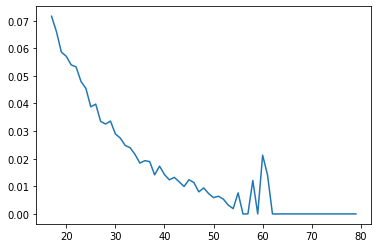

In [13]:
plt.plot(age_df['age'], age_df['conversion_rate'])

The conversion rate decreases as age increases but has a bump up around age 60.  

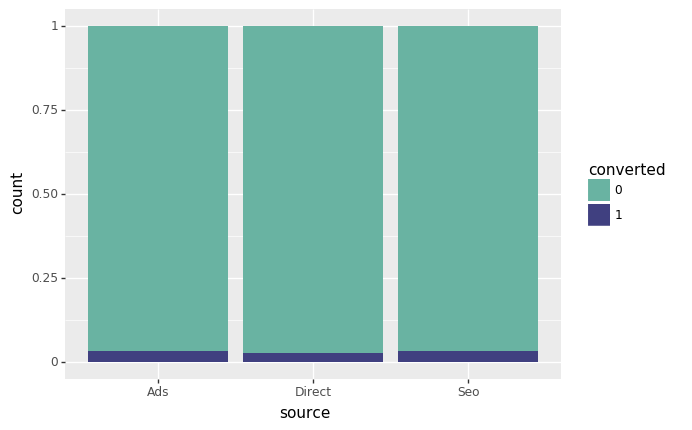

<ggplot: (8790549855617)>

In [14]:
df = df.astype({'converted':object})

bar_plot = ggplot(data = df , mapping = aes(x = 'source'))

(bar_plot+geom_bar(aes(fill = 'converted'),position='fill',stat = 'count')
 +plotnine.scale_fill_manual(values=["#69b3a2", "#404080"]))

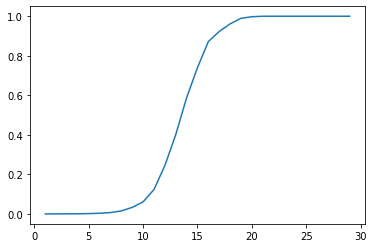

In [15]:
df = df.astype({'converted':int})
page_df = df[['total_pages_visited','converted']].groupby(by = 'total_pages_visited').mean()
page_df.rename(columns = {'converted':'conversion_rate'},inplace = True)
page_df.reset_index(inplace = True)
plt.plot(page_df['total_pages_visited'], page_df['conversion_rate'])

The conversion rate increases at the number of pages viewed increases. 

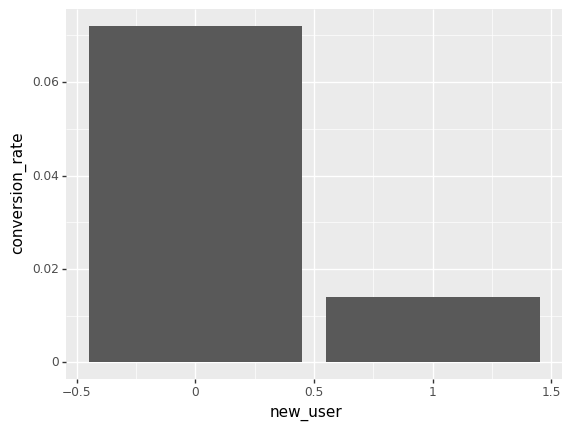

<ggplot: (8790568630985)>

In [16]:
df = df.astype({'converted':int})
user_df = df[['new_user','converted']].groupby(by = 'new_user').mean()
user_df.rename(columns = {'converted':'conversion_rate'},inplace = True)
user_df.reset_index(inplace = True)
ggplot(user_df,aes(x = 'new_user',y = 'conversion_rate'))+geom_bar(stat = "identity")


It is obvious that old users have a much higher conversion rate than new users

From the eda, we know that source is not relavant to convertion rate, while other inforamtin are somehow correlated with the convertion rate. Thus we can start feature engineering with the relavant metrics picked. 

In [17]:
feature = df.columns.difference(['source'])
feature

Index(['age', 'converted', 'country', 'new_user', 'total_pages_visited'], dtype='object')

In [18]:
df_encode = pd.DataFrame(pd.concat([df[['age','total_pages_visited','converted','new_user']]
                                    ,pd.get_dummies(df[['country']])],axis = 1))

scale the age and total page visited to within (0,1) range

In [19]:
df_encode.head()

,age,total_pages_visited,converted,new_user,country_China,country_Germany,country_UK,country_US
0,25,1,0,1,0,0,1,0
1,23,5,0,1,0,0,0,1
2,28,4,0,1,0,0,0,1
3,39,5,0,1,1,0,0,0
4,30,6,0,1,0,0,0,1


## deal with the imbalanced case 

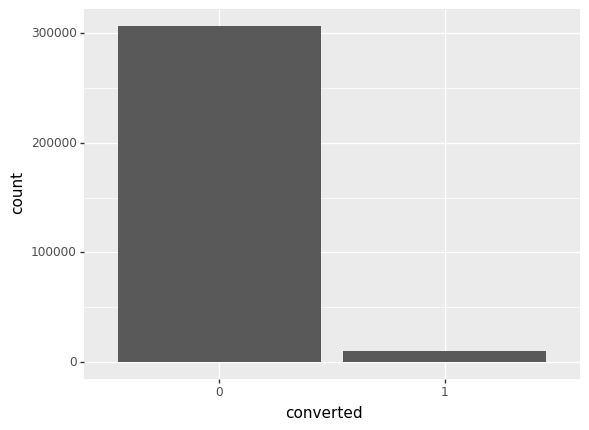

<ggplot: (8790551327245)>

In [20]:
#compare the converted(1) and nonconverted(0)
df = df.astype({'converted':object})
ggplot(df,aes(x = 'converted'))+geom_bar()


In [21]:
df = df.astype({'converted':int})
print(df[['converted']].mean())

converted    0.032252
dtype: float64


There are only 3% converted users in the dataset. The dataset is highly imbalanced. We may therefore use oversampling (SMOTE) to adjust the issue.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_encode[df_encode.columns.difference(['converted'])], df_encode['converted'], test_size=0.33, random_state=42)

In [23]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [24]:
X_train = X_train.append(X_res)
y_train = y_train.append(y_res)

## train a logistic regression model 

In [25]:
clf = make_pipeline(StandardScaler(),LogisticRegression(random_state=0)).fit(X_res, y_res)

## usd roc-auc to evaluate the performace of logistic regression 

In [26]:
plt.figure()
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

NameError: name 'fpr' is not defined

<Figure size 432x288 with 0 Axes>

0.937861322875462
(0.0, 0.0, 1.9999998281734126)
(0.0, 0.01718420259270425, 0.9999945720465815)
(0.0, 0.03316249623153452, 0.9999887196914822)
(0.0, 0.05396442568586072, 0.9999737479681751)
(0.0, 0.07084715104009648, 0.9999601253952431)
(0.0, 0.08863430810973771, 0.9999419008439306)
(0.0, 0.10853180584865843, 0.9999111587315154)
(0.0, 0.12842930358757915, 0.9998683510311134)
(9.89814805649863e-06, 0.14983418751884234, 0.9998019693494802)
(1.979629611299726e-05, 0.170937594211637, 0.999731416015354)
(2.969444416949589e-05, 0.18993066023515223, 0.9996437792820803)
(3.959259222599452e-05, 0.20952668073560446, 0.9995454598403357)
(5.938888833899178e-05, 0.23002713295146215, 0.9994305535902162)
(5.938888833899178e-05, 0.2490201989749774, 0.9993006783444744)
(8.908333250848766e-05, 0.2692191739523666, 0.9991407619647235)
(0.00010887962862148492, 0.2894181489297558, 0.9988967954482356)
(0.00012867592473448218, 0.31233041905336145, 0.9986426967307284)
(0.00014847222084747943, 0.335544166415435

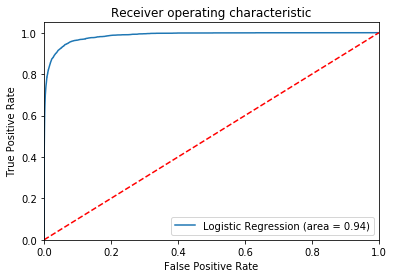

In [27]:
plt.figure()
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
print(logit_roc_auc)

#plot the ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
for i,row in enumerate(zip(fpr,tpr,thresholds)):
    if i%20==0:
        print(row)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

A 0.93 auc score is pretty good! 

## make prediciton on test dataset, decide the threshold through roc curve 

In [31]:
y_pred_proba = clf.predict_proba(X_test)[:,1]
th = 0.95
y_pred = [1 if i>=th else 0 for i in y_pred_proba]
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99    101029
           1       0.80      0.75      0.77      3317

    accuracy                           0.99    104346
   macro avg       0.90      0.87      0.88    104346
weighted avg       0.99      0.99      0.99    104346



Feature age, Score: -0.64433
Feature country_China, Score: -4.55843
Feature country_Germany, Score: -2.02737
Feature country_UK, Score: -3.58209
Feature country_US, Score: -4.51224
Feature new_user, Score: -0.94269
Feature total_pages_visited, Score: 4.72514


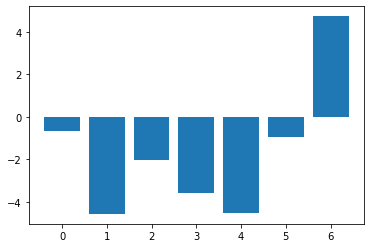

In [29]:
importance = clf.steps[1][1].coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature %0s, Score: %.5f' % (df_encode.columns.difference(['converted'])[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## recommendation for increase conversion rate
For the coefficients of logistic regression, heavily deviation away from 0 reflects the importance of the feature in conversion rate. Based on the results, the one with largest deviation is total_page_visited. The page_visit measures the time spent on each session and reflects user engagement. At the same time, the new users group has a lower conversion rate than old user group, which agrees with the conclusion we reached above. It suggests that the priority of product team is to booost user's retention rate and engagement.

On the other hand, the users from UK,US and Germany all have much higher conversion rate than those from China. One possible interpretation is that the language used on website is English only thus made it less attractive to users whose native language is not English. It can also because the culture difference in Asian and European country/US regions. It is thus strongly recommended that the UI could be modified for countries with different culture background. 

The third suggestion is that since the age of users do negatively affect the conversion rate a lot, it is possible that the webpage design targets teenagers and young people more than adults. Therefore the UI design can be improved to attract the interest of different age groups. 
